<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/Linea_de_espera_combi_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIMULACIÓN DE UNA PARADA DE COMBIS

**Contexto del problema:** En el paradero de Cuatro Caminos, en Naucalpan de Juárez, Estado de México, se observa que los pasajeros forman una fila para esperar la llegada de combis, las cuales operan bajo una disciplina de servicio de "primero en entrar, primero en salir" (FIFO). Es decir, las combis recogen a los pasajeros en el mismo orden en que estos llegaron a la fila. Este estudio tiene como objetivo realizar una simulación que permita comprender mejor el comportamiento del sistema y, con base en los resultados, proponer mejoras en los tiempos y la capacidad de las combis, con el fin de reducir los tiempos de espera excesivos para los pasajeros.

1. Para simular lo anterior, usaremos la libreria simpy que sirve para simulaciones de eventos discretos (como en una línea de espera), donde los eventos ocurren en puntos discretos en el tiempo. Esto es fundamental para modelar sistemas donde el tiempo de llegada y el servicio son importantes como es nuestro caso. Ademas agregaremos ptras librerias ya conocidas.

In [199]:
!pip install simpy

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import scipy.stats as st

2. Definimos los **parámetros principales** de la simulación, que reflejan el comportamiento del sistema de la parada de combis. Para ello, tendremos en cuenta lo siguiente:

* En promedio, un **pasajero** llega cada 5 minutos.  
-> Esto se puede modelar mediante una distribución exponencial (en teoría de colas, esta es común para modelar tiempos entre llegadas aleatorias).

*  El tiempo promedio entre la llegada de cada **combi**, sera de 20 minutos.
-> Esto implica que las combis llegan con menor frecuencia que los pasajeros, lo que puede generar una acumulación en la fila. De la misma manera que el caso anterior, podemos modelar este tiempo mediante unsa distribución exponencial.

* El tiempo promedio que tarda cada pasajero en **abordar** la combi sera de 1 minuto.
-> Este parámetro afecta el tiempo que la combi permanece en la parada recogiendo pasajeros. Similarmente se modelara el tiempo siguiendo una distribución exponencial.

* Es la **capacidad máxima** de cada combi (19 pasajeros).
-> Esta es una limitación física del sistema, ya que cada combi solo puede llevar hasta 19 personas. En la simulación, esto implicará que si la fila tiene más de 19 personas, el resto de pasajeros deberá esperar la próxima combi.

¿ Por que usar una distribución exponencial para modelar los tiempos que deseamos generar? : En un sistema de colas, los tiempos entre llegadas de eventos (como la llegada de pasajeros o combis) a menudo se modelan como variables aleatorias exponenciales cuando los eventos son independientes entre sí y ocurren a una tasa constante, que es nuestro caso.

In [275]:
# Parámetros
tiempo_llegada_pasajeros = 3           # Tasa de llegada de los pasajeros (1 cada 3 minutos)
tiempo_llegada_combis =  15            # Tasa de llegada de combis (1 cada 15 minutos)
cap_combi = 19                         # Capacidad máxima de pasajeros de cada combi
tiempo_prom_abordo = 0.5               # Tiempo promedio de abordo de cada pasajero (en minutos)

3. Asignaremos una variable llamada **tiempo_simulacion**, la cual definira el tiempo total que el simulador de eventos discretos (SimPy, en este caso) ejecutará el modelo, replicando el comportamiento de la fila de espera y la llegada de pasajeros y combis a lo largo de dos horas (120 minutos).

In [276]:
# Determinamos el tiempo de nuestra simulación (en minutos)
tiempo_simulacion=120

4. Creamos las siguientes listas que nos ayudaran a almacenar los datos generados durante la simulación, permitiendo realizar análisis estadísticos y visualizar los resultados, cada lista representara:

* Lista **longitud_cola**, la cual registrará la cantidad de pasajeros en la cola en diferentes momentos de la simulación.
-> Nos ayudara a analizar el nivel de acumulación de personas en la fila y detectar picos de esta acumulación.

* Lista **tiempo_espera**,almacenará el tiempo de espera de cada pasajero (desde que llega a la cola hasta que sube a una combi).
-> Ayudara a saber cual es el tiempo de espera de los pasajeros, asi mismo podramos obtener calculos como el tiempo de espera promedio.

* Lista **tiempos_abordo**, esta lista guarda el tiempo que cada pasajero tarda en abordar la combi.
-> Nos ayudara a entender si el proceso de abordaje contribuye a las demoras en nuestro sistema.

* Lista **combis_necesarias**,registra cuántas combis fueron necesarias para atender a todos los pasajeros a lo largo de la simulación.
-> Analizar el número de combis que llegan para satisfacer la demanda nos permitira verificar si la frecuencia de las combis es suficiente o si se requieren ajustes.

In [277]:
# Creamos nuestras listas para almacenar nuestros datos
longitud_cola=[]
tiempo_espera=[]
tiempos_abordo=[]
combis_necesarias=[]

5. Almacenaremos los tiempos de espera, longitud de la cola y combis necesarias promedio (o totales) del sistema para cada réplica de la simulación. Esto te permitirá calcular el promedio del tiempo de espera y intervalos de confianza para esta métrica en el conjunto de réplicas.

In [278]:
# Creamos otras listas para almacenas las replicaciones de la simulación
num_replicas = 365          # Veces que simularemos nuestro sistema (lo podemos ver como dias)
tiempos_espera_replicas = []
longitudes_cola_replicas = []
combis_necesarias_replicas = []

6. Creamos una función para simular la llegada de los pasajeros a la parada de combis. La frecuencia de llegada de los pasajeros sigue una distribución exponencial, de modo que el tiempo promedio entre llegadas, representado por la media, está definido como:

$$\mu = \frac{1}{\text{tiempo_llegada_pasajeros}}$$

donde **tiempo_llegada_pasajeros** es la tasa de llegada promedio de los pasajeros al sistema. Esto permite modelar la variabilidad en la llegada de los pasajeros, simulando un patrón de llegada aleatorio y realista.

**NOTA:** Los mensajes de impresión comentados en la función están desactivados para evitar visualizar cada evento de llegada en múltiples réplicas de la simulación. Para ver el comportamiento del sistema de un día, se puede reducir el número de réplicas a 1 y eliminar el símbolo **#** en las líneas de impresión correspondientes.



In [279]:
# Función para simular la llegada de pasajeros a la parada de combis

def llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero):
    numero_pasajero = 1  # Contador para identificar cada pasajero

    #Generamos un flujo continuo de llegadas de pasajeros hasta que se termine el tiempo de simulación

    while True:
        # Tiempos de llegada de los pasajeros (distribución exponencial)
        tiempo_ll_pas = np.random.exponential(1 / tiempo_llegada_pasajeros)
        yield env.timeout(tiempo_ll_pas)

        pasajero = f'--- El pasajero número {numero_pasajero}'
        #print(f'{pasajero} llegó en el minuto {env.now:.2}----')

        cola_pasajeros.put((pasajero, env.now))  # Guardamos el tiempo de llegada del pasajero
        tiempo_pasajero.append(env.now)  # Guardamos el tiempo de llegada del pasajero

        numero_pasajero += 1  # Incrementamos el contador de pasajeros

        # Actualizamos la longitud de la cola
        longitud_cola.append(len(cola_pasajeros.items))


7. Ahora creamos la función **llegada_combis** que nos ayudara a simular el proceso de llegada de combis al paradero, asi como el abordaje de los pasajeros que esperan en la fila. En esta simulación, las combis llegan en intervalos de tiempo que siguen una distribución exponencial, donde el tiempo promedio de llegadas sere igual a:

$$\mu = \frac{1}{\text{tiempo_llegada_combis}}$$

Cada combi tiene una capacidad máxima y los pasajeros abordan en orden de llegada hasta llenar la combi o vaciar la fila.

Ademas el tiempo que cada pasajero tarda en abordar sigue una distribución exponencial, lo que permitira analizar el comportamiento de este proceso de abordaje en condiciones realistas.

Estos datos ayudarán a entender cuántas combis son necesarias para satisfacer la demanda y los tiempos de espera promedio, permitiendo así evaluar y optimizar nuestro sistema.

In [280]:
# Función para simular la llegada de las combis al paradero
def llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero):
    numero_combi = 1  # Contador para identificar cada combi

    while True:
        # Tiempo de llegada de combis (distribución exponencial)
        tiempo_ll_com = np.random.exponential(1 / tiempo_llegada_combis)
        yield env.timeout(tiempo_ll_com)

        # Asignamos una forma de identificar el numero de combis que llegan
        combi = f' La combi número {numero_combi}'
        #print(f'{combi} llegó en el minuto {env.now:.2f} ***')

        pasajeros = []  # Almacenaremos cuantos pasajeros abordaran esta combi en particular
        tiempo_abordo_combi = 0 # Acomulamos el tiempo total de abordaje de esta combi

        # Las personas abordan la combi hasta que se llena
        while len(pasajeros) < cap_combi and len(cola_pasajeros.items) > 0:
            pasajero, tiempo_ll_pas = yield cola_pasajeros.get()  # Persona sube a la combi
            pasajeros.append(pasajero)
            tiempo_abordo_combi += np.random.exponential(tiempo_prom_abordo)  # Tiempo de abordo de cada persona
            tiempo_espera_pasajero = env.now - tiempo_ll_pas # env.now corresponde al tiempo actual de la simulacion
            tiempo_espera.append(tiempo_espera_pasajero)
          #print(f'{pasajero} subió a {combi} después de {tiempo_espera_pasajero:.3f} minutos de espera +++')

        # La combi parte con los pasajeros
        combis.put(pasajeros)
        #print(f'{combi} se fue con {len(pasajeros)} pasajeros <--.')

        # Registrar el tiempo de abordo promedio por combi
        tiempos_abordo.append(tiempo_abordo_combi / len(pasajeros) if pasajeros else 0)

        # Para calcular el número total de combis necesarias
        combis_necesarias.append(numero_combi)
        numero_combi += 1  # Incrementa la cantidad de combis


8. Finalmente creamos la función **simular()** la cual ejecuta una simulación de nuestro sistema de linea de espera, esto para lograr evaluar el rendimiento del servicio en múltiples calculos (como el tiempo de espera de los pasajeros y la cantidad de combis necesarias). Esta función realiza varias replicaciones (corridas independientes de la simulación) para obtener resultados más confiables. Durante cada replicación, la función registra el promedio de cada métrica y, al finalizar, calcula intervalos de confianza para interpretar la precisión de estos promedios.

* Dado que el número de replicaciones puede no ser muy grande, los intervalos de confianza se calcularan utilizando la distribución **t-Student** en lugar de la normal. La distribución t-Student es ideal cuando el **tamaño de la muestra es pequeño o se desconoce la varianza de la población**, ya que es más conservadora y ajusta la variabilidad de los datos con menor cantidad de observaciones.
-> Al calcular estos intervalos de confianza, podemos determinar el rango en el que esperamos que se encuentren los verdaderos valores promedio de cada métrica con un 95% de comfiabilidad.

* Los gráficos que generaremos mostraran los valores promedio de cada métrica (tiempo de espera, longitud de la cola, combis necesarias) en cada replicación. Esto nos permitira observar la variabilidad entre replicaciones y verificar si el sistema es estable. Cada gráfico incluira una línea de referencia con la media global de las replicaciones, que ayudara a identificar si alguna replicación presenta valores atípicos o desviaciones significativas.


In [281]:
def simular():
    print("\n   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX ")

    # Ejecución de múltiples replicaciones
    for i in range(num_replicas):
        env = simpy.Environment() # Entorno de SimPy donde ocurren todos los eventos de la simulación
        cola_pasajeros = simpy.Store(env)  # Cola de pasajeros
        combis = simpy.Store(env)  # Cola de combis
        tiempo_pasajero = []  # Para guardar el tiempo de llegada de los pasajeros a la cola

        # Arrancamos los procesos de llegada de pasajeros y combis
        env.process(llegada_pasajeros(env, cola_pasajeros, tiempo_pasajero))
        env.process(llegada_combis(env, cola_pasajeros, combis, tiempo_pasajero))

        # Ejecutamos la simulación hasta el tiempo que indicamos
        env.run(until=tiempo_simulacion)

        # Visualizamos los resultados finales, solo de la primera replica
        if i == 0:
            print("\n *********************************************************************************")
            print("\n---> Resultados de la primera replica de la simulación <---")
            print(f"\n--- Tiempo de espera de pasajeros: {len(tiempo_espera)} minutos ---")
            print(f"Promedio del tiempo de espera de pasajeros: {np.mean(tiempo_espera):.2f} minutos")
            print(f"\n--- Longitud de la cola de pasajeros: {len(longitud_cola)} personas ---")
            print(f"Promedio de la longitud de la cola de pasajeros: {np.mean(longitud_cola):.2f} personas")
            print(f"\n---- Combis necesarias: {len(longitud_cola)/cap_combi:.2f} combis ---")
            print(f"Promedio de combis necesarias: {np.mean(combis_necesarias):.2f} combis")
            print("\n *********************************************************************************")

        # Guardamos resultados de esta replicación
        tiempos_espera_replicas.append(np.mean(tiempo_espera) if tiempo_espera else 0)
        longitudes_cola_replicas.append(np.mean(longitud_cola) if longitud_cola else 0)
        combis_necesarias_replicas.append(np.mean(combis_necesarias) if combis_necesarias else 0)

    # Calculamos los intervalos de confianza para los resultados
    def intervalo_confianza(datos):
        mean = np.mean(datos)
        # Ajustamos la fórmula para compensar el hecho de que estamos trabajando con una muestra y no con la población completa
        std = np.std(datos, ddof=1)  # Usar la desviación estándar muestral con grados de libertad (ddof=1)
        n = len(datos)
        t = st.t.ppf(0.975, df=n-1)  # Valor t para 95% de confianza y n-1 grados de libertad
        margen_error = t * (std / np.sqrt(n))
        return mean - margen_error, mean + margen_error

    # Mostramos los resultados de todas las replicaciones generadas en la simulacion
    print("\n *********************************************************************************")
    print("\n---> Resultados de la simulación con intervalos de confianza <---")

    # Tiempo de espera
    mean_tiempo_espera = np.mean(tiempos_espera_replicas)
    ci_tiempo_espera = intervalo_confianza(tiempos_espera_replicas)
    print(f"\n--- Tiempo de espera de pasajeros: {len(tiempo_espera)} minutos ---")
    print(f"Promedio del tiempo de espera de pasajeros: {mean_tiempo_espera:.2f} minutos")
    print(f"Intervalo de confianza (95%) para el tiempo de espera: [ {ci_tiempo_espera[0]:.2f} , {ci_tiempo_espera[1]:.2f} ]  minutos")

    # Longitud de la cola
    mean_longitud_cola = np.mean(longitudes_cola_replicas)
    ci_longitud_cola = intervalo_confianza(longitudes_cola_replicas)
    print(f"\n--- Longitud de la cola de pasajeros: {len(longitud_cola)} personas ---")
    print(f"Promedio de la longitud de la cola de pasajeros: {mean_longitud_cola:.2f} personas")
    print(f"Intervalo de confianza (95%) para la longitud de la cola: [ {ci_longitud_cola[0]:.2f} , {ci_longitud_cola[1]:.2f} ] personas")

    # Número de combis necesarias
    mean_combis_necesarias = np.mean(combis_necesarias_replicas)
    ci_combis_necesarias = intervalo_confianza(combis_necesarias_replicas)
    print(f"\n---- Combis necesarias: {len(longitud_cola)/cap_combi:.2f} combis ---")
    print(f"Promedio de combis necesarias: {mean_combis_necesarias:.2f} combis")
    print(f"Intervalo de confianza (95%) para el número de combis necesarias: [ {ci_combis_necesarias[0]:.2f} , {ci_combis_necesarias[1]:.2f} ] combis")

    print("\n\n *********************************************************************************")
    print("\n\m ---------------    G    R    Á    F    I    C    A    S    ---------------")

    # Graficar el tiempo de espera de los pasajeros
    plt.figure(figsize=(10, 6))
    plt.plot(tiempos_espera_replicas,color='#800080')
    plt.axhline(y=np.mean(tiempos_espera_replicas), color='r', linestyle='--', label=f'Media: {np.mean(tiempos_espera_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Tiempo de espera promedio (minutos)")
    plt.title("Tiempo de espera promedio por replicación")
    plt.grid(True)
    plt.gca().set_facecolor('#F8F8FF')
    plt.legend()
    plt.show()


        # Graficar la longitud de la cola promedio por replicación
    plt.figure()
    plt.figure(figsize=(10, 6))
    plt.plot(longitudes_cola_replicas,color='#00308F')
    plt.axhline(y=np.mean(longitudes_cola_replicas), color='r', linestyle='--', label=f'Media: {np.mean(longitudes_cola_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Longitud de la cola promedio")
    plt.title("Longitud de la cola promedio por replicación")
    plt.grid(True)
    plt.gca().set_facecolor('#F0FFFF')
    plt.legend()
    plt.show()

    # Graficar el promedio de combis necesarias por replicación
    plt.figure()
    plt.figure(figsize=(10, 6))
    plt.plot(combis_necesarias_replicas,color='#FF69B4')
    plt.axhline(y=np.mean(combis_necesarias_replicas), color='r', linestyle='--', label=f'Media: {np.mean(combis_necesarias_replicas):.2f}')
    plt.xlabel("Número de replicación")
    plt.ylabel("Promedio de combis necesarias")
    plt.title("Promedio de combis necesarias por replicación")
    plt.grid(True)
    plt.gca().set_facecolor('#FFF0F5')
    plt.legend()
    plt.show()


   XXXXXXXXXXXXX S  I  M  U  L  A  C  I  Ó  N XXXXXXXXXXXXX 

 *********************************************************************************

---> Resultados de la primera replica de la simulación <---

--- Tiempo de espera de pasajeros: 318 minutos ---
Promedio del tiempo de espera de pasajeros: 0.07 minutos

--- Longitud de la cola de pasajeros: 318 personas ---
Promedio de la longitud de la cola de pasajeros: 1.23 personas

---- Combis necesarias: 16.74 combis ---
Promedio de combis necesarias: 907.50 combis

 *********************************************************************************

 *********************************************************************************

---> Resultados de la simulación con intervalos de confianza <---

--- Tiempo de espera de pasajeros: 131143 minutos ---
Promedio del tiempo de espera de pasajeros: 0.07 minutos
Intervalo de confianza (95%) para el tiempo de espera: [ 0.07 , 0.07 ]  minutos

--- Longitud de la cola de pasajeros: 131204 perso

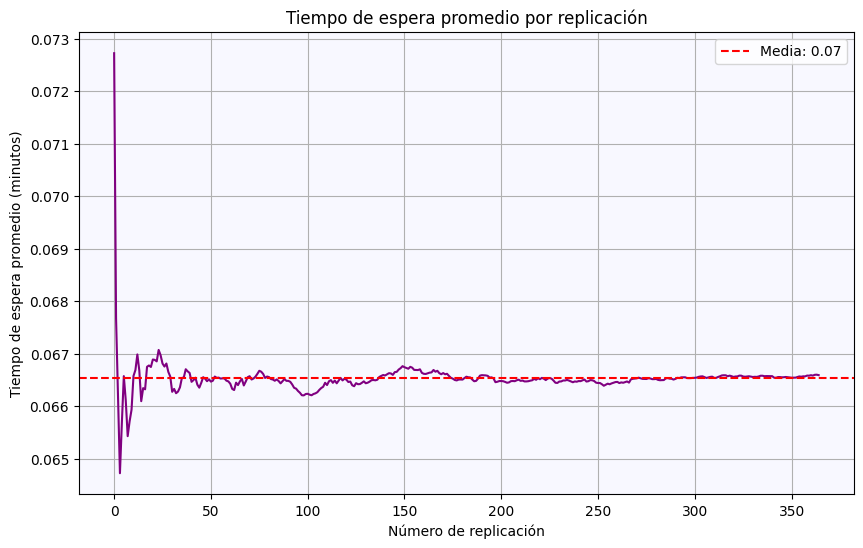

<Figure size 640x480 with 0 Axes>

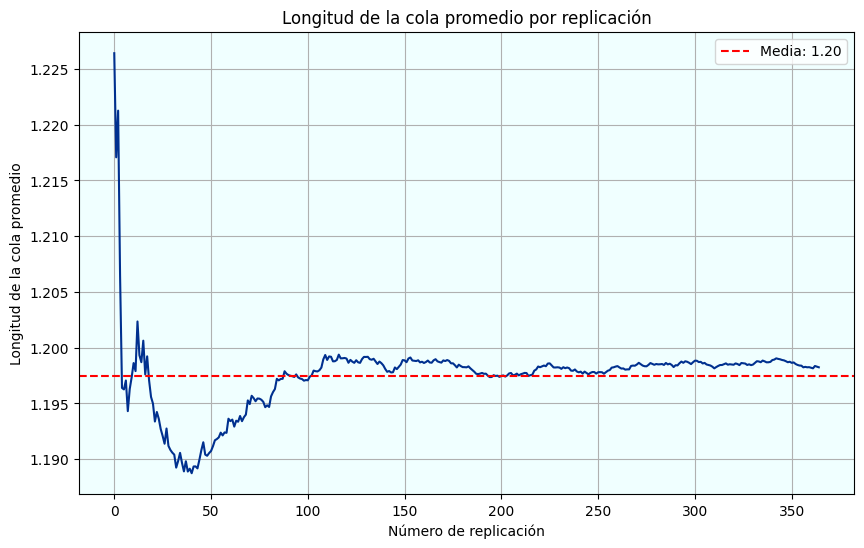

<Figure size 640x480 with 0 Axes>

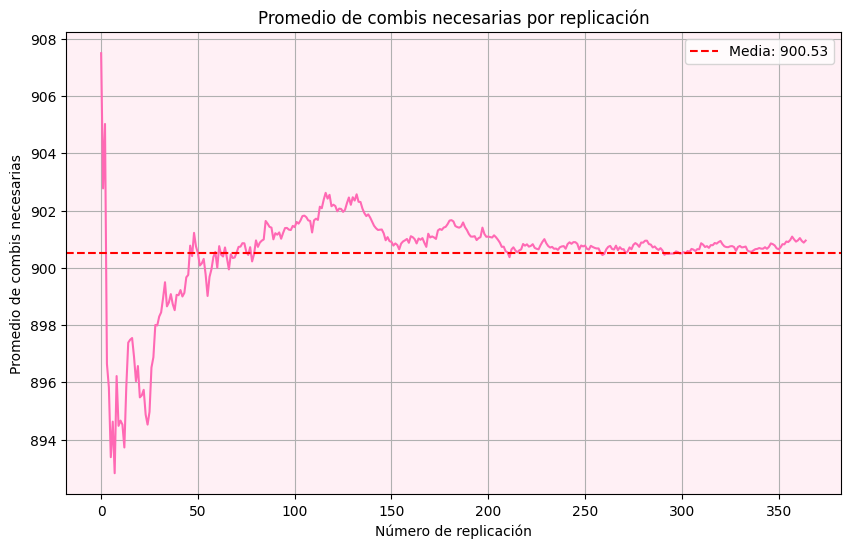

In [282]:
# Ejecutamos la simulación
simular()

## C O N C L U S I O N

En la ejecución que se muestra en pantalla, podemos observar que el tiempo de espera promedio es de 0.07 minutos, lo cual es relativamente bajo. Un tiempo de espera bajo y cercano a un valor ideal (como 0 minutos) puede ser un indicio de que nuestro sistema está funcionando de manera eficiente. Además, podemos ver gráficamente que nuestros tiempos de espera convergen rápidamente a la media, lo cual sugiere que los parámetros seleccionados para la simulación han sido adecuados para optimizar nuestros tiempos de espera. Estos parámetros incluyen:

* tiempo_llegada_pasajeros = 3
* tiempo_llegada_combis = 15
* cap_combi = 19
* tiempo_prom_abordo = 0.5

Esto implica que los parámetros establecidos contribuyen a un buen desempeño del sistema, con tiempos de espera bajos y una buena fluidez en el transporte.

Asimismo, observamos que tanto la gráfica de longitud de la cola como la de las combis promedio convergen rápidamente a la media. Esto indica que el sistema está alcanzando una situación de equilibrio o estabilidad después de aproximadamente 200 simulaciones (este dato se puede verificar observando la convergencia en las tres gráficas). La rápida estabilización sugiere que el sistema está operando de manera predecible y eficiente.

Finalmente, dado que el tiempo de espera promedio es bajo (en nuestro caso, 0.07 minutos) y el intervalo de confianza es estrecho, esto refuerza la idea de que el sistema está bien optimizado. La estrechez del intervalo de confianza indica que los resultados son consistentes y confiables, lo que sugiere que el sistema ha alcanzado un rendimiento óptimo.

** NOTA : ** Recordemos que estamos simulando el comportamiento de nuestro sistema durante 2 horas diarias por un año.